Create a SVD low-rank model of the noise data, for each of the three time periods. The model should be based on the whole time period, and the results reported for each time period. Compare this with a "global model" which is based on the ensemble average of all stations over each of the three time periods. In additional, compare the global model to ensemble averages and SVD low-rank models for each of the four regions. In total, you will have five resulting models: one global model with all regions + four regional models using station data from each region.

Time periods:
Day: 07:00-19:00
Evening: 19:00-23:00
Night: 23:00-07:00

Execute the following cell to connect your google drive to the colab. Needed to load the data stored on your personal google drive. In case you use a local environment just comment out the following lines of code.

In [11]:
from google.colab import drive
drive.mount('/content/drive')
drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [13]:
if drive is not None and drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']

list_df = []
sensor_names = []
region_list = []

for folder in folders:
    for file in os.listdir(dir_path + folder):
        sensor_name = file.split('-')[0]
        region_list.append(int(folder.split('_')[1]))
        sensor_names.append(file.split('-')[0])
        df = pd.read_csv(dir_path + folder + "/" + file, index_col=None, header=0)
        df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
        df.rename(columns={'dt_sound_level_dB': sensor_name}, inplace=True)
        list_df.append(df)

In [14]:
start_time = datetime.strptime('2022.08.01 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.08.13 23:59:00', '%Y.%m.%d %H:%M:%S')

df_counter = 0

for df in list_df:
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]

    start_row = pd.DataFrame({'Time': start_time, 'dt_sound_level_dB': df.iloc[0][sensor_names[df_counter]]}, index=[0])
    start_row['Time'] = pd.to_datetime(start_row['Time'])

    end_row = pd.DataFrame({'Time': end_time, sensor_names[df_counter]: df.iloc[-1][sensor_names[df_counter]]}, index=[0])
    end_row['Time'] = pd.to_datetime(end_row['Time'])

    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')

    if not (df.index == end_time).any():
        df.loc[end_time] = [df.iloc[-1][sensor_names[df_counter]]]

    if not (df.index == start_time).any():
        df.loc[start_time] = [df.iloc[0][sensor_names[df_counter]]]

    df = df.sort_values(by='Time')
    df_counter += 1
    # print(df.head())
    # print(df.tail())
    # print("--------------------------------------------------")


In [15]:
import datetime

dt = start_time
step = datetime.timedelta(minutes=1)
result = []

while dt < end_time:
    result.append(dt.strftime('%Y.%m.%d %H:%M:%S'))
    dt += step

col = {'Time': result, 'dummy': 0}
df_all_timestamps = pd.DataFrame(data=col)
df_all_timestamps['Time'] = pd.to_datetime(df_all_timestamps['Time'])
df_all_timestamps = df_all_timestamps.set_index('Time')

print(df_all_timestamps.head())

del df_counter, dt, start_time, end_time

                     dummy
Time                      
2022-08-01 00:00:00      0
2022-08-01 00:01:00      0
2022-08-01 00:02:00      0
2022-08-01 00:03:00      0
2022-08-01 00:04:00      0


In [16]:
list_df_inter = []
df_counter = 0
df_all_data = df_all_timestamps.drop('dummy', axis=1)

for df in list_df:
    df = df_all_timestamps.merge(df, how='left', on='Time')
    df = df.drop('dummy', axis=1)

    while df[sensor_names[df_counter]].isnull().values.any():
        df = df.interpolate(method='bfill', limit=1)
        df = df.interpolate(method='ffill', limit=1)

    df = df.set_index('Time')
    df = df.resample('1T').mean()
    df_counter += 1
    df_all_data = df_all_data.merge(df, how='left', on='Time')

del df_counter, df_all_timestamps, list_df

In [36]:
d = {'sensor names':sensor_names,'region':region_list}
sensors = pd.DataFrame(d)
sensors_region1 = sensors[sensors['region'] == 1]['sensor names']
sensors_region2 = sensors[sensors['region'] == 2]['sensor names']
sensors_region3 = sensors[sensors['region'] == 3]['sensor names']
sensors_region4 = sensors[sensors['region'] == 4]['sensor names']

print(df_all_data[sensors_region1])

                     2028  2093  2225  2078  2214  2233  2004  226E  2043  \
Time                                                                        
2022-08-01 00:00:00  56.0  50.0  46.0  53.0  45.0  44.0  54.0  46.0  53.0   
2022-08-01 00:01:00  56.0  53.0  46.0  53.0  45.0  44.0  54.0  46.0  53.0   
2022-08-01 00:02:00  56.0  52.0  46.0  49.0  45.0  44.0  58.0  46.0  53.0   
2022-08-01 00:03:00  56.0  60.0  46.0  49.0  45.0  44.0  58.0  46.0  53.0   
2022-08-01 00:04:00  56.0  58.0  46.0  56.0  45.0  44.0  54.0  46.0  53.0   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-08-13 23:54:00  54.0  60.0  47.0  57.0  45.0  44.0  56.0  46.0  56.0   
2022-08-13 23:55:00  54.0  60.0  47.0  51.0  45.0  44.0  53.0  46.0  57.0   
2022-08-13 23:56:00  59.0  57.0  47.0  51.0  45.0  44.0  53.0  46.0  54.0   
2022-08-13 23:57:00  59.0  62.0  47.0  57.0  45.0  44.0  57.0  46.0  60.0   
2022-08-13 23:58:00  59.0  61.0  47.0  57.0  45.0  44.0  57.0  46.0  61.0   

In [40]:
def calc_SVD_RMSE(df):
    U, s, Vt = np.linalg.svd(df)

    rank_range = range(1, len(df.columns) + 1)
    rmse_list = []
    amount_sing_values = []

    for rank in rank_range:
        Sigma = np.zeros((df.shape[0], df.shape[1]))
        Sigma[:rank, :rank] = np.diag(s[:rank])
        df_recon = U.dot(Sigma.dot(Vt))

        rmse = np.sqrt(np.mean((df - df_recon)**2))
        rmse_list.append(rmse.mean())
        amount_sing_values.append(Sigma[rank-1][rank-1])

    return rmse_list, amount_sing_values
    

In [42]:
df_all_data.reset_index(inplace=True)
df_without_timestamp = df_all_data.iloc[:, 1:len(df_all_data.columns)+1]

rmse_list_reg1, amount_sing_val_reg1 = calc_SVD_RMSE(df_without_timestamp[sensors_region1])
rmse_list_reg2, amount_sing_val_reg2 = calc_SVD_RMSE(df_without_timestamp[sensors_region2])
rmse_list_reg3, amount_sing_val_reg3 = calc_SVD_RMSE(df_without_timestamp[sensors_region3])
rmse_list_reg4, amount_sing_val_reg4 = calc_SVD_RMSE(df_without_timestamp[sensors_region4])

print('Region 1:')
for rank in range(len(rmse_list_reg1)):
        print(f'Rank: {rank+1} RMSE: {rmse_list_reg1[rank]} Amount Singular Values: {amount_sing_val_reg1[rank]}')

print('Region 2:')
for rank in range(len(rmse_list_reg2)):
        print(f'Rank: {rank+1} RMSE: {rmse_list_reg2[rank]} Amount Singular Values: {amount_sing_val_reg2[rank]}')

print('Region 3:')
for rank in range(len(rmse_list_reg3)):
        print(f'Rank: {rank+1} RMSE: {rmse_list_reg3[rank]} Amount Singular Values: {amount_sing_val_reg3[rank]}')

print('Region 4:')
for rank in range(len(rmse_list_reg4)):
        print(f'Rank: {rank+1} RMSE: {rmse_list_reg4[rank]} Amount Singular Values: {amount_sing_val_reg4[rank]}')

Region 1:
Rank: 1 RMSE: 3.6347089518100977 Amount Singular Values: 56885.28331473521
Rank: 2 RMSE: 3.4186587807918207 Amount Singular Values: 1276.68963333606
Rank: 3 RMSE: 3.2608712288589037 Amount Singular Values: 1152.0826401552802
Rank: 4 RMSE: 3.121262242432193 Amount Singular Values: 987.7724563266462
Rank: 5 RMSE: 3.0250885319446668 Amount Singular Values: 828.5587233653115
Rank: 6 RMSE: 2.9417819492432304 Amount Singular Values: 744.4252190043985
Rank: 7 RMSE: 2.8684944665595054 Amount Singular Values: 685.1425735509091
Rank: 8 RMSE: 2.8128781694764355 Amount Singular Values: 589.2458619434806
Rank: 9 RMSE: 2.759125037074812 Amount Singular Values: 581.9004380077558
Rank: 10 RMSE: 2.7047434664352297 Amount Singular Values: 565.9326991631903
Rank: 11 RMSE: 2.648903600400773 Amount Singular Values: 554.6990058314032
Rank: 12 RMSE: 2.597003942307918 Amount Singular Values: 545.6871214518345
Rank: 13 RMSE: 2.545247149852797 Amount Singular Values: 540.208936626532
Rank: 14 RMSE: 2.

In [48]:
amount_sing_val_reg1[0] = amount_sing_val_reg1[1] * 2
amount_sing_val_reg2[0] = amount_sing_val_reg2[1] * 2
amount_sing_val_reg3[0] = amount_sing_val_reg3[1] * 2
amount_sing_val_reg4[0] = amount_sing_val_reg4[1] * 2

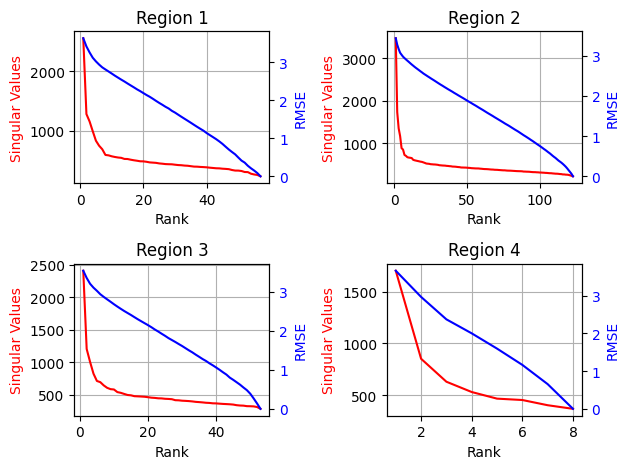

In [49]:
def init_ax(ax, rank_values, rmse_values, sing_values, color1, color2):
  ax.set_xlabel('Rank')
  ax.set_ylabel('Singular Values', color=color1)
  ax.plot(rank_values, sing_values, color=color1)
  ax2 = ax.twinx()
  ax2.set_ylabel('RMSE', color=color2)
  ax2.plot(rank_values, rmse_values, color=color2)
  ax2.tick_params(axis='y', labelcolor=color2)
  ax.grid(True)
  ax2.grid(False)
  return ax

rank_range_reg1 = range(1, len(rmse_list_reg1) + 1)
rank_range_reg2 = range(1, len(rmse_list_reg2) + 1)
rank_range_reg3 = range(1, len(rmse_list_reg3) + 1)
rank_range_reg4 = range(1, len(rmse_list_reg4) + 1)

color1 = 'r'
color2 = 'b'

fig, ax = plt.subplots(2,2)
ax[0, 0] = init_ax(ax[0, 0], rank_range_reg1, rmse_list_reg1, amount_sing_val_reg1, color1, color2)
ax[0, 1] = init_ax(ax[0, 1], rank_range_reg2, rmse_list_reg2, amount_sing_val_reg2, color1, color2)
ax[1, 0] = init_ax(ax[1, 0], rank_range_reg3, rmse_list_reg3, amount_sing_val_reg3, color1, color2)
ax[1, 1] = init_ax(ax[1, 1], rank_range_reg4, rmse_list_reg4, amount_sing_val_reg4, color1, color2)

ax[0, 0].set_title('Region 1')
ax[0, 1].set_title('Region 2')
ax[1, 0].set_title('Region 3')
ax[1, 1].set_title('Region 4')

fig.tight_layout()
plt.show()

Presentation Content:

Choose the kth final rank, and explain why you choose that particular value.

Provide a figure showing the singular values vs. RMSE (compared with the global and regional models) for each of the three time periods, and use it to justify your kth rank.

Select at least three different stations based on their location in the city, choose each station from a different region.

Apply one or more of the SVD models made in the previous steps of the individual different stations chosen in the previous step by randomly sub-sampling your data matrix. Compare the results to your kth rank SVD model using the RMSE and the median absolute deviation.